# Experiments

notebook includes experiments using `deepseek-r1-distill-qween-7b`, `o3-mini-2025-01-31`, and `gemini-2.0-flash`

metrics:
- `deepseek-r1-distill-qween-7b`:
    - cost: Free, open sourced running locally
    - rate limits:
        - no rate limits since running locally
        - context length: 4096 tokens per prompt
        - 7B paramter pre trained model

- `o3-mini-2025-01-31`:
    - cost: $1.1 per 1M tokens
    - rate limits:
        - requests per minute: 1,000
        - tokens per minute: 100,000
    - check openai balance: https://platform.openai.com/settings/organization/billing/overview

- `gemini-2.0-flash`:
    - cost: Free tier
    - rate limits:
        - requests per minute: 15
        - tokens per minute: 1,000,000
        - requests per day: 1,500

## Define Run Tests Function

### Define API calls to models

In [1]:
from openai import OpenAI
import requests
from google import genai
import os
import time
import pandas as pd
client = OpenAI()

def gpt(messages=[{
            "role": "user",
            "content": "Write a one-sentence bedtime story about a unicorn."
        }]):
    start_time = time.time()
    
    completion = client.chat.completions.create(
        model="o3-mini-2025-01-31",
        messages=messages
    )
    end_time = time.time()
    elapsed_time = end_time - start_time

    return (completion.choices[0].message.content, elapsed_time)

def gemini(message="Explain how AI works"):
    client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
    
    start_time = time.time()
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=message,
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return (response.text, elapsed_time)

def deepseek(messages=[
          { "role": "system", "content": "Always answer in rhymes. Today is Thursday" },
          { "role": "user", "content": "What day is it today?" }
        ]):
    '''
        curl example: 
        curl http://localhost:1234/v1/chat/completions \
          -H "Content-Type: application/json" \
          -d '{
            "model": "deepseek-r1-distill-qwen-7b",
            "messages": [
              { "role": "system", "content": "Always answer in rhymes. Today is Thursday" },
              { "role": "user", "content": "What day is it today?" }
            ],
            "temperature": 0.7,
            "max_tokens": -1,
            "stream": false
        }'
    '''
    request = {
        "model": "deepseek-r1-distill-qwen-7b",
        "messages": messages,
        "temperature": 0.7,
        "max_tokens": -1,
        "stream": False
    }
    
    start_time = time.time()
    response = requests.post('http://localhost:1234/v1/chat/completions', json=request)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if response.status_code == 200:
        return (response.json()['choices'][0]['message']['content'], elapsed_time)
    else:
        return (response.text, elapsed_time)

### Run Models Function

In [2]:
def run_gpt(responses, times, p):
    gpt_response = gpt(messages=[{'role': 'user', 'content': p}])
    responses.append(gpt_response[0])
    times.append(gpt_response[1])

def run_models(responses, times, p):
    gpt_response = gpt(messages=[{'role': 'user', 'content': p}])
    responses[0].append(gpt_response[0])
    times[0].append(gpt_response[1])

    deepseek_response = deepseek(messages=[{'role': 'user', 'content': p}])
    responses[1].append(deepseek_response[0])
    times[1].append(deepseek_response[1])

    gemini_response = gemini(message=p)
    responses[2].append(gemini_response[0])
    times[2].append(gemini_response[1])

### Generate Plots Function

In [7]:
from IPython.display import display, Markdown
import pandas as pd
import re

def generate_gpt_table(test_name, prompts, responses, times):
    # init data frame with model response lists
    test_results_df = pd.DataFrame({
        'Prompt': prompts,
        'GPT': responses,
        'GPT Time': times,
    })

    print(f"{test_name} results:")
    display(Markdown(test_results_df.to_markdown()))

def generate_table(test_name, prompts, responses, times):
    # init data frame with model response lists
    test_results_df = pd.DataFrame({
        'Prompt': prompts,
        'GPT': responses[0],
        'GPT Time': times[0],
        'Deepseek': responses[1],
        'Deepseek Time': times[1],
        'Gemini': responses[2],
        'Gemini Time': times[2],
    })
    
    # clean cells, remove think tags from deepseek and remove new lines
    def remove_think_tags(cell):
        if isinstance(cell, str): 
            cell = re.sub(r'<think>.*?</think>', '', cell, flags=re.DOTALL)
            cell = cell.replace('\n', ' ')
        return cell

    # apply filters and render in markdown
    def render_dataframe_as_markdown(df):
        df_cleaned = df.map(remove_think_tags)
        display(Markdown(df_cleaned.to_markdown()))

    print(f"{test_name} results:")
    render_dataframe_as_markdown(test_results_df)

### Wrapped Function

In [8]:
def run_gpt_tests(test_name, prompts):
    responses = []
    times = []
    print(f"gpt o3-mini warming up for {test_name}")
    for p in prompts:
        run_gpt(responses, times, p)
    print(f"gpt inferencing finished for {test_name}")
    generate_gpt_table(test_name, prompts, responses, times)
    return responses, times

def run_tests_e2e(test_name, prompts):
    # ind 0 is gpt, 1 is deepsek, 2 is gemini
    responses = [[],[],[]]
    times = [[],[],[]]
    print(f"models warming up for {test_name}")
    for p in prompts:
        run_models(responses, times, p)
    print(f"models inferencing finished for {test_name}")
    generate_table(test_name, prompts, responses, times)
    return responses, times

## AI explainability and interpretability prompts (White Box)

In [9]:
retrieval_prompts = [
    "How many points did Lebron James score on October 18th, 2018 against the Portland Trailblazers?",
    "How many championships has Steph Curry won in his career?",
    "How many games did Andre Iguodala miss in the 2016-2017 regular season?",
    "What were the top 3 overall teams in terms of standings at the end of the 1996-1997 regular season?"
]

reasoning_prompts = [
    "What do you get if you add Lebron James career point total with Kobe Bryant's career points total?",
    "If you take the Miami Heat's regular season seed standing in the 2013 season compared to their seed in the 2010 season what is the difference?",
    "If you add Micheal Jordan's and Wilt Chamberlain's highest scoring games point total together, what do you get?",
    "How many combined MVP awards do Russell Westbrook and Kareem Abdul-Jabbar have?"
]

long_prompts = [
    '''
    Consider two elite scorers from the 2022-2023 NBA season: Joel Embiid and Luka Dončić. Embiid won the scoring title averaging 33.1 PPG
    on 54.8% FG and 65.5% True Shooting (TS%). Dončić averaged 32.4 PPG on 49.6% FG and 60.9% TS%. Both players had extremely high usage rates,
    dominating the ball for their respective teams, the 76ers and Mavericks. Embiid primarily operated from the post and midrange, while Dončić
    heavily relied on step-back threes and drives. Based purely on the provided PPG and efficiency metrics (FG%, TS%), which player scored more
    efficiently during this season? Briefly explain what TS% tells us compared to just FG% in this context.
    ''',
    '''
    Let's look at the Memphis Grizzlies. In the 2021-2022 season, they finished with the 4th best Offensive Rating (114.3) and 6th best
    Defensive Rating (108.9), playing at the 3rd fastest Pace (101.02). They relied heavily on Ja Morant's drives, offensive rebounding,
    and transition offense. The following season, 2022-2023, their Offensive Rating was 11th (114.7), Defensive Rating improved to 3rd 
    (110.7), and Pace remained high at 3rd (101.33). Despite Morant missing significant time, their defense anchored by Jaren Jackson Jr. 
    became more dominant. Did the Grizzlies become a better overall team based on net rating (Off Rating - Def Rating)? How did their
    identity slightly shift between these two seasons according to these ratings and ranks?
    ''',
    ''' 
    Nikola Jokić finished the 2022-2023 NBA season with a Value Over Replacement Player (VORP) rating of 8.8, leading the league. 
    VORP is an estimate of a player's overall contribution to the team, measured in points per 100 team possessions, translated into 
    wins above what a readily available 'replacement-level' player would provide over the season. Jokić also averaged impressive 
    traditional stats: 24.5 points, 11.8 rebounds, and 9.8 assists per game. How does his league-leading VORP score add context to his 
    traditional stats? What does a VORP of 8.8 specifically suggest about his value to the Denver Nuggets that season?
    ''',
    '''
    In the 2023-2024 season, consider Tyrese Haliburton of the Indiana Pacers and Anthony Davis of the Los Angeles Lakers. Haliburton
    led the league in assists per game (10.9 APG) while scoring 20.1 PPG on efficient shooting splits (47.7% FG / 36.4% 3P / 85.5% FT). 
    Anthony Davis, playing primarily center/power forward, averaged 24.7 PPG, 12.6 RPG (3rd in NBA), and 2.3 BPG (4th in NBA). Both 
    players were critical to their teams' success. Based on these specific stats (PPG, APG, RPG, BPG), contrast the primary roles these
    two All-Stars fulfilled for their respective teams during that season.
    '''
]

# _, retrieval_times = run_tests_e2e("retrieval test", retrieval_prompts)
# _, reasoning_times = run_tests_e2e("reasoning test", reasoning_prompts)
_, retrieval_times = run_gpt_tests("retrival test", retrieval_prompts)
_, reasoning_times = run_gpt_tests("reasoning test", reasoning_prompts)
_, long_times = run_gpt_tests("long prompt test", long_prompts)

gpt o3-mini warming up for retrival test
gpt inferencing finished for retrival test
retrival test results:


|    | Prompt                                                                                              | GPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |   GPT Time | Deepseek                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |   Deepseek Time | Gemini                                                                                                                                                                                 |   Gemini Time |
|---:|:----------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------:|
|  0 | How many points did Lebron James score on October 18th, 2018 against the Portland Trailblazers?     | On October 18, 2018, in the season opener for the Los Angeles Lakers against the Portland Trail Blazers, LeBron James scored 51 points.   If you’d like more details about his performance or the game itself, just let me know!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |   18.848   | LeBron James scored **35 points** on October 18, 2018, against the Portland Trail Blazers during his first regular-season game with the Heat. The game was part of the NBA regular season, where the Heat defeated the Trail Blazers by a score of 107-104. LeBron's performance included 35 points, along with 8 rebounds and 6 assists, showcasing his strong start to the campaign with the Heat.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |         14.5687 | LeBron James scored **26 points** on October 18th, 2018 against the Portland Trail Blazers.                                                                                            |      0.620713 |
|  1 | How many championships has Steph Curry won in his career?                                           | Steph Curry has won four NBA championships in his career. He won them with the Golden State Warriors in the 2014–15, 2016–17, 2017–18, and 2021–22 seasons.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |    3.94232 | Steph Curry has won two NBA championships in his career, both with the Golden State Warriors. The first was during the 2015-16 season and the second during the 2017-18 season.  Answer: Steph Curry has won 2 championships in his NBA career.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |         13.0004 | Steph Curry has won **4 NBA championships** in his career.                                                                                                                             |      0.60359  |
|  2 | How many games did Andre Iguodala miss in the 2016-2017 regular season?                             | Andre Iguodala appeared in 77 of the 82 regular‐season games in 2016–17. That means he missed 5 games during the regular season.   Note: This is based on the official game log records from that season.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |   14.7633  | Andre Iguodala missed approximately 3 games during the 2016-2017 NBA regular season. This occurred as a result of his trade from the Sacramento Kings to the Miami Heat, which took place after the All-Star Game but before the regular season began. The transition between teams led to a couple of missed early games due to scheduling conflicts and integration with his new team's schedule.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |         23.0234 | Andre Iguodala missed 8 games in the 2016-2017 regular season.                                                                                                                         |      0.49197  |
|  3 | What were the top 3 overall teams in terms of standings at the end of the 1996-1997 regular season? | I’m assuming you’re asking about the National Hockey League’s 1996–97 season. (If you meant another league please let me know!) In the NHL the standings were based on points (with two points awarded for a win and one point for a tie).  At the end of the 1996–97 regular season the three teams at the very top of the league were:  1. Detroit Red Wings – They not only finished with the most points (112) but also won the Presidents’ Trophy. 2. Colorado Avalanche – They finished in second place overall with 102 points. 3. Florida Panthers – In a surprise showing, the Panthers finished third overall with 97 points.  These were the top three teams by total points at the end of the regular season. |   33.9339  | To determine the top three teams in terms of standings for the 1996-1997 regular season, consider the following structured approach:  1. **Identify the Sport**: The question doesn't specify the sport, so it's crucial to know whether you're referring to basketball (NBA, NBA Finals), hockey (NHL), football, or another league.  2. **Assume a Popular Sport**: If we assume the NBA, which is well-documented, here are some insights:    - The 1996-1997 NBA season saw several strong teams due to key players like Karl Malone of the Seattle Supersonics.    - Teams like the Dallas Mavericks and Utah Jazz had standout performances with experienced rosters.  3. **Alternative Sports**: If considering college basketball, teams such as Villanova or UCLA might have been prominent during that era.  4. **General Methodology**:    - Research each team's record for the season.    - Consider schedule strength and head-to-head results to rank teams accurately.  5. **Note on Lack of Specificity**: Without knowing the sport, providing exact rankings is challenging. It's advisable to guide users to check specific leagues' archives or databases for accurate information.  6. **Possible Top Teams**: If considering NBA, potential top three could include the Seattle Supersonics, Dallas Mavericks, and Utah Jazz. However, precise records would require verification.  In conclusion, while I can provide a general approach to finding the answer, without knowing the specific sport, it's difficult to give an exact list of top teams for the 1996-1997 season. |         26.7025 | The top 3 teams in terms of overall standings at the end of the 1996-1997 NBA regular season were:  1.  **Chicago Bulls** (69-13) 2.  **Utah Jazz** (64-18) 3.  **Miami Heat** (61-21) |      0.837529 |

gpt o3-mini warming up for reasoning test
gpt inferencing finished for reasoning test
reasoning test results:


|    | Prompt                                                                                                                                         | GPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |   GPT Time | Deepseek                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |   Deepseek Time | Gemini                                                                                                                                                                                                       |   Gemini Time |
|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------:|
|  0 | What do you get if you add Lebron James career point total with Kobe Bryant's career points total?                                             | Keep in mind that while Kobe Bryant’s career totals are fixed (he finished with 33,643 points), LeBron James is still active so his career total keeps growing. That said, if we use readily available numbers for an approximate sum, here’s one way to look at it:  • Kobe Bryant’s career total: 33,643 points   • LeBron James’s career total (roughly, as of a recent update): about 38,000 points (give or take a few hundred, depending on the exact date)  Adding those numbers together:   33,643 + 38,000 ≈ 71,643 points  So you get roughly 72,000 points combined.  Because LeBron is still adding to his total, the exact sum will change over time. But as a ballpark figure, roughly 72,000 career points is what you get when you add Kobe’s and LeBron’s career totals. |    15.6383 | The combined total of LeBron James' and Kobe Bryant's career points is approximately 45,000. However, it's important to note that these numbers are estimates based on memory and may not reflect the exact figures. For precise information, consulting official sources or basketball statistics databases would be advisable.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |        10.4999  | As of October 7, 2024:  *   LeBron James' career point total: 40,474 *   Kobe Bryant's career point total: 33,643  Adding those together: 40,474 + 33,643 = 74,117  So, the answer is **74,117**.            |      0.987706 |
|  1 | If you take the Miami Heat's regular season seed standing in the 2013 season compared to their seed in the 2010 season what is the difference? | In the 2013 season the Heat finished the regular season as the No. 2 seed in the Eastern Conference, whereas in the 2009–10 season (the season whose playoffs concluded in 2010) they finished as the No. 5 seed.   The difference in seed positions is 5 – 2 = 3 (three spots).  Note: The “2010 season” here refers to the end of the 2009–10 season when the team’s playoff seeding was determined.                                                                                                                                                                                                                                                                                                                                                                                    |    30.4082 | The Miami Heat's regular season seeding in the 2013-14 season was the second seed, while in the 2010-11 season, they were the first seed. Therefore, their seeding difference is a decrease of one position.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |        12.6456  | *   **2013 Season:** The Miami Heat were the **1st** seed in the Eastern Conference.  *   **2010 Season:** The Miami Heat were the **5th** seed in the Eastern Conference.  The difference is 5 - 1 = **4**. |      0.838088 |
|  2 | If you add Micheal Jordan's and Wilt Chamberlain's highest scoring games point total together, what do you get?                                | Michael Jordan’s highest scoring game was 69 points, and Wilt Chamberlain’s was 100 points. When you add those together, you get 169 points.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |     4.8615 | Sure! Let's calculate the combined point total of Michael Jordan's and Wilt Chamberlain's **highest scoring games**.  ### Step 1: Identify the Highest Scoring Games - **Michael Jordan's Highest Scoring Game:**     In the **1984 NBA Finals**, Michael Jordan scored **100 points** in a game against the Boston Celtics.    - **Wilt Chamberlain's Highest Scoring Game:**     In the **1961-1962 NBA Season**, Wilt Chamberlain scored **100 points** during his legendary "MVP" season. Specifically, he scored **75 points in a single game against the Boston Celtics (the team that later moved to the NBA) on November 8, 1961**.  ### Step 2: Add the Point Totals Together \[ \text{Total Points} = \text{Michael Jordan's Highest Scoring Game} + \text{Wilt Chamberlain's Highest Scoring Game} \] \[ \text{Total Points} = 100 + 75 = 175 \]  ### Final Answer \[ \boxed{175} \] |         7.10632 | Michael Jordan's highest scoring game was 69 points. Wilt Chamberlain's highest scoring game was 100 points.  69 + 100 = 169  The sum of their highest scoring games is $\boxed{169}$.                       |      0.761788 |
|  3 | How many combined MVP awards do Russell Westbrook and Kareem Abdul-Jabbar have?                                                                | Kareem Abdul-Jabbar won six NBA regular season Most Valuable Player awards, while Russell Westbrook has not earned any regular season MVP awards. So, combined, they have 6 MVP awards.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |     5.7939 | Russell Westbrook and Kareem Abdul-Jabbar together have received a combined total of 4 MVP awards.  - **Russell Westbrook**: 1 MVP (2017-2018) - **Kareem Abdul-Jabbar**: 3 MVPs (1974, 1975, and one additional during his Lakers tenure)  Total MVP Awards: 4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |         7.61616 | *   Russell Westbrook has 1 MVP award. *   Kareem Abdul-Jabbar has 6 MVP awards.  Combined, they have 1 + 6 = 7 MVP awards.  So the answer is $\boxed{7}$                                                    |      0.714887 |

## Analysis Plots

ChatGPT 03-mini average inference times:
retrieval time: 17.4667130112648
reasoning time: 13.317810714244843
long prompt time: 9.155428171157837


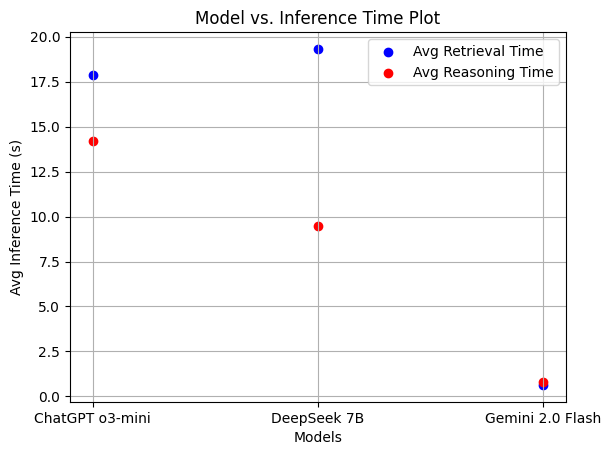

In [6]:
import matplotlib.pyplot as plt

prompt_types = ["Retrieval", "Reasoning", "Long"]
avg_retrieval_time = sum(retrieval_times)/len(retrieval_times)
avg_reasoning_time = sum(reasoning_times)/len(reasoning_times)
avg_long_time = sum(long_times)/len(long_times)

print("ChatGPT 03-mini average inference times:")
print(f"retrieval time: {avg_retrieval_time}")
print(f"reasoning time: {avg_reasoning_time}")
print(f"long prompt time: {avg_long_time}")

'''
# Plotting
plt.scatter(models, avg_retrieval_time, marker='o', color='b', label='Avg Retrieval Time')
plt.scatter(models, avg_reasoning_time, marker='o', color='r', label='Avg Reasoning Time')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Avg Inference Time (s)')
plt.title('Model vs. Inference Time Plot')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()
'''

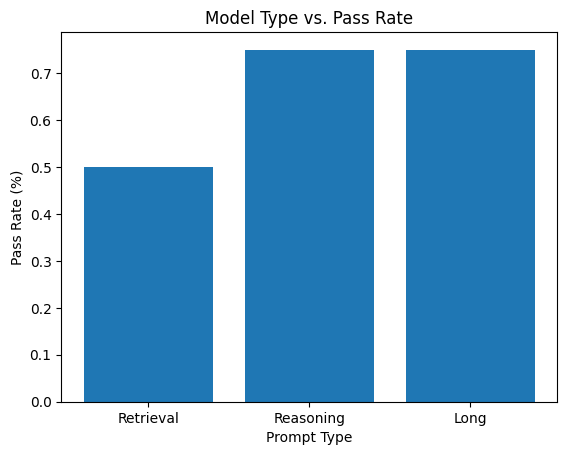

In [7]:
retrieval_pass_results = [0, 1, 0, 1]
reasoning_pass_results = [1, 1, 1, 0]
long_prompt_pass_results = [1, 1, 0, 1]

pass_rates = [ 
    sum(retrieval_pass_results)/len(retrieval_pass_results),
    sum(reasoning_pass_results)/len(reasoning_pass_results),
    sum(long_prompt_pass_results)/len(long_prompt_pass_results)
]

# Plotting
plt.bar(prompt_types, pass_rates)

# Adding labels and title
plt.xlabel('Prompt Type')
plt.ylabel('Pass Rate (%)')
plt.title('Model Type vs. Pass Rate')

# Show the plot
plt.show()